In [1]:
import re
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import math
pd.set_option('display.max_rows', 100)

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler


# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
genre_data = pd.read_csv('../../new_dataset/noveltmmeta/metadata/titlemeta.tsv', sep = '\t', encoding = 'utf-8', low_memory=False)

In [3]:
genre_data = genre_data[["docid","author", "genres", "title", "startdate", "subjects" ]]
genre_data.head()

,docid,author,genres,title,startdate,subjects
0,mdp.39015031913893,"Spencer, Louise Reid",NaN,Guerrilla wife | $c: [by] Louise Reid Spencer.,||||,"Personal narratives, American|Philippines|Worl..."
1,mdp.39015003936864,"Baker, Robert H",NaN,The suburbs : | a novel / | $c: by Robert H. B...,,NaN
2,mdp.39015068342305,"Dickens, Charles",NaN,Edwin Drood. | $c: By Charles Dickens. With il...,,NaN
3,mdp.39015055066586,"Stretton, Hesba",NaN,"Carola, | $c: by Hesba Stretton.",,NaN
4,mdp.39015055066594,"Stretton, Hesba",NaN,In prison & out. | $c: By Hesba Stretton.,,NaN


In [4]:
genre_1900 = genre_data.loc[genre_data['startdate'] > '1900', ["docid","author", 'genres', "title", "startdate", "subjects"]]

In [5]:
char_1900 = pd.read_csv('../project-data/character_table_post1900/character_table_post1900.tsv', sep = '\t', encoding = 'utf-8')

In [6]:
char_1900.head()

,docid,charname,charid,gender,pubdate,words
0,chi.60782167,Spencer,chi.60782167|Spencer,m,1984,opened enter thought realised told awareness c...
1,chi.60782167,DrMelrose,chi.60782167|DrMelrose,u,1984,said took doubled knew knew came person good w...
2,chi.60782167,MrsKirk,chi.60782167|MrsKirk,f,1984,caused arrived making had turn has turned know...
3,chi.60782167,Kevin,chi.60782167|Kevin,m,1984,said expect going wanted said hearing stay ski...
4,chi.60782167,DrSmidt,chi.60782167|DrSmidt,m,1984,present said sighed fumbled gave said read off...


In [7]:
merged_data = pd.merge(char_1900, genre_1900, on = 'docid')

In [8]:
merged_data.startdate.nunique()

118

In [9]:
merged_data.head()

,docid,charname,charid,gender,pubdate,words,author,genres,title,startdate,subjects
0,chi.60782167,Spencer,chi.60782167|Spencer,m,1984,opened enter thought realised told awareness c...,"Pridmore, Saxby",Bibliographies,The case of Joshua Kirk : | an episode of schi...,1984,Case studies|Schizophrenia
1,chi.60782167,DrMelrose,chi.60782167|DrMelrose,u,1984,said took doubled knew knew came person good w...,"Pridmore, Saxby",Bibliographies,The case of Joshua Kirk : | an episode of schi...,1984,Case studies|Schizophrenia
2,chi.60782167,MrsKirk,chi.60782167|MrsKirk,f,1984,caused arrived making had turn has turned know...,"Pridmore, Saxby",Bibliographies,The case of Joshua Kirk : | an episode of schi...,1984,Case studies|Schizophrenia
3,chi.60782167,Kevin,chi.60782167|Kevin,m,1984,said expect going wanted said hearing stay ski...,"Pridmore, Saxby",Bibliographies,The case of Joshua Kirk : | an episode of schi...,1984,Case studies|Schizophrenia
4,chi.60782167,DrSmidt,chi.60782167|DrSmidt,m,1984,present said sighed fumbled gave said read off...,"Pridmore, Saxby",Bibliographies,The case of Joshua Kirk : | an episode of schi...,1984,Case studies|Schizophrenia


In [10]:
merged_data.dropna(subset = ["docid"], inplace=True)
merged_data.dropna(subset = ["genres"], inplace=True)
merged_data.dropna(subset = ["subjects"], inplace=True)
merged_data['gender'].value_counts()

m    166881
f     76056
u     36990
Name: gender, dtype: int64

In [11]:
merged_data= merged_data[merged_data['gender'] != 'u']

<AxesSubplot:title={'center':'Gender proportions'}>

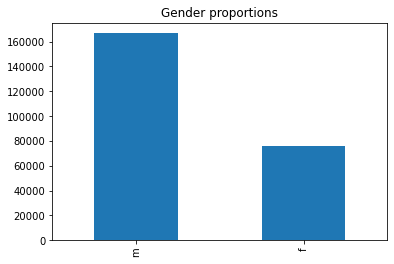

In [12]:
merged_data['gender'].value_counts().plot(kind='bar', title='Gender proportions')

How do gender roles differ across different genres?

In [13]:
merged_data['genres'] = merged_data['genres'].str.lower()
merged_data['Romance'] = merged_data['genres'].str.contains('love|erotic|regency|romance|bildungsroman|romantic|lesbian') | merged_data['subjects'].str.contains('love|erotic|regency|romance|bildungsroman|romantic|lesbian')
merged_data['Sci-fi'] = merged_data['genres'].str.contains('science|star') | merged_data['subjects'].str.contains('science|star')
merged_data['Horror'] = merged_data['genres'].str.contains('horror|ghost|gothic') | merged_data['subjects'].str.contains('horror|ghost|gothic')
merged_data['Religious'] = merged_data['genres'].str.contains('religion|religious|christ|jew') | merged_data['subjects'].str.contains('religion|religious|christ|jew')
merged_data['Psychological'] = merged_data['genres'].str.contains('psychology|psychological') | merged_data['subjects'].str.contains('psychology|psychological')
merged_data['Historical'] = merged_data['genres'].str.contains('history|war|historical') | merged_data['subjects'].str.contains('history|war|historical')
merged_data['Suspense'] = merged_data['genres'].str.contains('detective|mystery|suspense|spy|thriller|legal') | merged_data['subjects'].str.contains('detective|mystery|suspense|spy|thriller|legal')
merged_data['Comedy'] = merged_data['genres'].str.contains('humor|humorous|humour|comedy|satire') | merged_data['subjects'].str.contains('humor|humorous|humour|comedy|satire')
merged_data['Sports'] = merged_data['genres'].str.contains('tennis|baseball|sports') | merged_data['subjects'].str.contains('tennis|baseball|sports')
merged_data['Non-Fiction'] = merged_data['genres'].str.contains('legends|biography|aut|juvenile|bibliographies') | merged_data['subjects'].str.contains('legends|biography|aut|juvenile|bibliographies')
merged_data['Medical_Experimental'] = merged_data['genres'].str.contains('medical|experimental') | merged_data['subjects'].str.contains('medical|experimental')
merged_data['Statistics_Political'] = merged_data['genres'].str.contains('statistics|political') | merged_data['subjects'].str.contains('statistics|political')
merged_data['Fantasy'] = merged_data['genres'].str.contains('occult|fantasy') | merged_data['subjects'].str.contains('occult|fantasy')

In [14]:
rows = []
for column in merged_data[['Romance','Sci-fi','Horror','Religious','Psychological','Historical','Suspense','Comedy','Sports','Non-Fiction','Medical_Experimental','Statistics_Political','Fantasy']]:
    columnSeriesObj = merged_data[column]
    year_count = merged_data[merged_data[column]==True]
    total_count = year_count.shape[0]
    male_count = year_count[year_count.gender=='m']
    male_count = male_count.shape[0]
    female_count = year_count[year_count.gender=='f']
    female_count = female_count.shape[0]
    male_fraction = male_count/total_count
    female_fraction = female_count/total_count
    rows.append([column, male_count, female_count, male_fraction, female_fraction ])

#print(rows)
genre_df = pd.DataFrame(rows, columns = ['Genres', 'Male', 'Female', 'FractionMale', 'FractionFemale'])
#print(df)
genre_df.head(20)

,Genres,Male,Female,FractionMale,FractionFemale
0,Romance,17913,10489,0.630695,0.369305
1,Sci-fi,3200,1126,0.739713,0.260287
2,Horror,2937,1241,0.702968,0.297032
3,Religious,3159,1463,0.683470,0.316530
4,Psychological,11259,6261,0.642637,0.357363
5,Historical,18826,6825,0.733929,0.266071
6,Suspense,29655,11985,0.712176,0.287824
7,Comedy,7258,3503,0.674473,0.325527
8,Sports,675,163,0.805489,0.194511
9,Non-Fiction,48095,20587,0.700256,0.299744


<AxesSubplot:xlabel='Genres'>

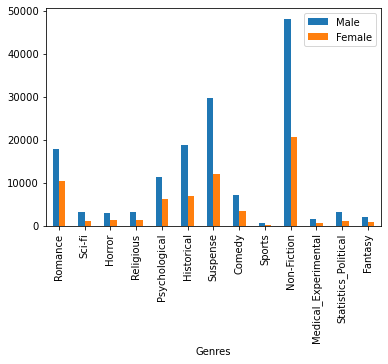

In [15]:
genre_df.plot(x="Genres", y=["Male","Female"], kind="bar")

How gender roles have evolved over the decades? 

In [16]:
merged_data['year1900_1910'] = (merged_data['pubdate'] > 1900) & (merged_data['pubdate'] <= 1910)
merged_data['year1910_1920'] = (merged_data['pubdate'] > 1910) & (merged_data['pubdate'] <= 1920)
merged_data['year1920_1930'] = (merged_data['pubdate'] > 1920) & (merged_data['pubdate'] <= 1930)
merged_data['year1930_1940'] = (merged_data['pubdate'] > 1930) & (merged_data['pubdate'] <= 1940)
merged_data['year1940_1950'] = (merged_data['pubdate'] > 1940) & (merged_data['pubdate'] <= 1950)
merged_data['year1950_1960'] = (merged_data['pubdate'] > 1950) & (merged_data['pubdate'] <= 1960)
merged_data['year1960_1970'] = (merged_data['pubdate'] > 1960) & (merged_data['pubdate'] <= 1970)
merged_data['year1970_1980'] = (merged_data['pubdate'] > 1970) & (merged_data['pubdate'] <= 1980)
merged_data['year1980_1990'] = (merged_data['pubdate'] > 1980) & (merged_data['pubdate'] <= 1990)
merged_data['year1990_2000'] = (merged_data['pubdate'] > 1990) & (merged_data['pubdate'] <= 2000)
merged_data['year2000_2010'] = (merged_data['pubdate'] > 2000) & (merged_data['pubdate'] <= 2010)
merged_data['year2010_2020'] = (merged_data['pubdate'] > 2010) & (merged_data['pubdate'] <= 2020)

In [17]:
rows = []
for column in merged_data[['year1900_1910','year1910_1920','year1920_1930','year1930_1940','year1940_1950','year1950_1960','year1960_1970','year1970_1980','year1980_1990','year1990_2000','year2000_2010']]:
    columnSeriesObj = merged_data[column]
    year_count = merged_data[merged_data[column]==True]
    total_count = year_count.shape[0]
    male_count = year_count[year_count.gender=='m']
    male_count = male_count.shape[0]
    female_count = year_count[year_count.gender=='f']
    female_count = female_count.shape[0]
    male_fraction = male_count/total_count
    female_fraction = female_count/total_count
    rows.append([column, male_count, female_count, male_fraction, female_fraction ])

#print(rows)
gender_df = pd.DataFrame(rows, columns = ['Year', 'Male', 'Female', 'FractionMale', 'FractionFemale'])
#print(df)
gender_df.head(20)

,Year,Male,Female,FractionMale,FractionFemale
0,year1900_1910,1428,569,0.715073,0.284927
1,year1910_1920,1319,480,0.733185,0.266815
2,year1920_1930,2906,1078,0.729418,0.270582
3,year1930_1940,3478,1553,0.691314,0.308686
4,year1940_1950,3883,1746,0.689821,0.310179
5,year1950_1960,4358,1732,0.715599,0.284401
6,year1960_1970,5435,2038,0.727285,0.272715
7,year1970_1980,9675,3386,0.740755,0.259245
8,year1980_1990,14567,6285,0.698590,0.301410
9,year1990_2000,66466,31368,0.679375,0.320625


<AxesSubplot:xlabel='Year'>

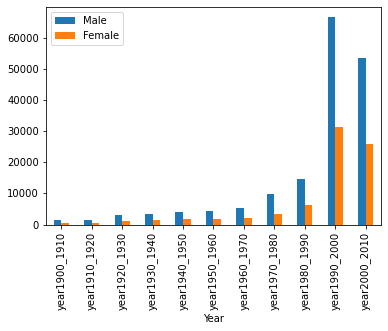

In [18]:
gender_df.plot(x="Year", y=["Male","Female"], kind="bar")

In [19]:
rows = []
for column in merged_data[['year1900_1910','year1910_1920','year1920_1930','year1930_1940','year1940_1950','year1950_1960','year1960_1970','year1970_1980','year1980_1990','year1990_2000','year2000_2010']]:
    columnSeriesObj = merged_data[column]
    year_count = merged_data[merged_data[column]==True]
    for i in year_count[['Romance','Sci-fi','Horror','Religious','Psychological','Historical','Suspense','Comedy','Sports','Non-Fiction','Fantasy']]:
        columnSeriesObj = merged_data[i]
        year_count = merged_data[merged_data[i]==True]
        total_count = year_count.shape[0]
        male_count = year_count[year_count.gender=='m']
        male_count = male_count.shape[0]
        female_count = year_count[year_count.gender=='f']
        female_count = female_count.shape[0]
        male_fraction = male_count/total_count
        female_fraction = female_count/total_count
        rows.append([column, i, male_count, female_count, male_fraction, female_fraction ])

#print(rows)
gender_df = pd.DataFrame(rows, columns = ['Year', 'Genre', 'Male', 'Female', 'FractionMale', 'FractionFemale'])
#print(df)
gender_df.head(20)

,Year,Genre,Male,Female,FractionMale,FractionFemale
0,year1900_1910,Romance,17913,10489,0.630695,0.369305
1,year1900_1910,Sci-fi,3200,1126,0.739713,0.260287
2,year1900_1910,Horror,2937,1241,0.702968,0.297032
3,year1900_1910,Religious,3159,1463,0.683470,0.316530
4,year1900_1910,Psychological,11259,6261,0.642637,0.357363
5,year1900_1910,Historical,18826,6825,0.733929,0.266071
6,year1900_1910,Suspense,29655,11985,0.712176,0.287824
7,year1900_1910,Comedy,7258,3503,0.674473,0.325527
8,year1900_1910,Sports,675,163,0.805489,0.194511
9,year1900_1910,Non-Fiction,48095,20587,0.700256,0.299744


How do authors respond to the Feminism Wave?

In [21]:
author_data = pd.read_csv('../../char_dataset/character/metadata/filtered_fiction_plus_18c.tsv', sep = '\t', encoding = 'utf-8', low_memory=False)

In [22]:
author_data.head()

,docid,volid,recordid,author,firstname,inferreddate,birthdate,authgender,enumcron,title
0,14930,uva.x004123163,NaN,"Swift, Jonathan,",Jonathan,1784,NaN,m,v.1,The works of the Rev. Dr. Jonathan Swift
1,14931,uva.x004123168,NaN,"Swift, Jonathan,",Jonathan,1784,NaN,m,v.6,The works of the Rev. Dr. Jonathan Swift
2,14932,uva.x030576706,NaN,"Swift, Jonathan,",Jonathan,1784,NaN,m,v.11,The works of the Rev. Dr. Jonathan Swift
3,14933,uva.x000530839,NaN,"Swift, Jonathan,",Jonathan,1784,NaN,m,v.12,The works of the Rev. Dr. Jonathan Swift
4,14934,nyp.33433076096019,NaN,"Swift, Jonathan,",Jonathan,1784,NaN,m,v. 14,The works of the Rev. Dr. Jonathan Swift


In [23]:
author_data['year1900_1910'] = (author_data['inferreddate'] > 1900) & (author_data['inferreddate'] <= 1910)
author_data['year1910_1920'] = (author_data['inferreddate'] > 1910) & (author_data['inferreddate'] <= 1920)
author_data['year1920_1930'] = (author_data['inferreddate'] > 1920) & (author_data['inferreddate'] <= 1930)
author_data['year1930_1940'] = (author_data['inferreddate'] > 1930) & (author_data['inferreddate'] <= 1940)
author_data['year1940_1950'] = (author_data['inferreddate'] > 1940) & (author_data['inferreddate'] <= 1950)
author_data['year1950_1960'] = (author_data['inferreddate'] > 1950) & (author_data['inferreddate'] <= 1960)
author_data['year1960_1970'] = (author_data['inferreddate'] > 1960) & (author_data['inferreddate'] <= 1970)
author_data['year1970_1980'] = (author_data['inferreddate'] > 1970) & (author_data['inferreddate'] <= 1980)
author_data['year1980_1990'] = (author_data['inferreddate'] > 1980) & (author_data['inferreddate'] <= 1990)
author_data['year1990_2000'] = (author_data['inferreddate'] > 1990) & (author_data['inferreddate'] <= 2000)
author_data['year2000_2010'] = (author_data['inferreddate'] > 2000) & (author_data['inferreddate'] <= 2010)
author_data['year2010_2020'] = (author_data['inferreddate'] > 2010) & (author_data['inferreddate'] <= 2020)

In [24]:
author_data.head()

,docid,volid,recordid,author,firstname,inferreddate,birthdate,authgender,enumcron,title,...,year1920_1930,year1930_1940,year1940_1950,year1950_1960,year1960_1970,year1970_1980,year1980_1990,year1990_2000,year2000_2010,year2010_2020
0,14930,uva.x004123163,NaN,"Swift, Jonathan,",Jonathan,1784,NaN,m,v.1,The works of the Rev. Dr. Jonathan Swift,...,False,False,False,False,False,False,False,False,False,False
1,14931,uva.x004123168,NaN,"Swift, Jonathan,",Jonathan,1784,NaN,m,v.6,The works of the Rev. Dr. Jonathan Swift,...,False,False,False,False,False,False,False,False,False,False
2,14932,uva.x030576706,NaN,"Swift, Jonathan,",Jonathan,1784,NaN,m,v.11,The works of the Rev. Dr. Jonathan Swift,...,False,False,False,False,False,False,False,False,False,False
3,14933,uva.x000530839,NaN,"Swift, Jonathan,",Jonathan,1784,NaN,m,v.12,The works of the Rev. Dr. Jonathan Swift,...,False,False,False,False,False,False,False,False,False,False
4,14934,nyp.33433076096019,NaN,"Swift, Jonathan,",Jonathan,1784,NaN,m,v. 14,The works of the Rev. Dr. Jonathan Swift,...,False,False,False,False,False,False,False,False,False,False


In [25]:
author_data= author_data[author_data['authgender'] != 'u']
rows = []
for column in author_data[['year1900_1910','year1910_1920','year1920_1930','year1930_1940','year1940_1950','year1950_1960','year1960_1970','year1970_1980','year1980_1990','year1990_2000','year2000_2010']]:
    columnSeriesObj = author_data[column]
    year_count = author_data[author_data[column]==True]
    total_count = year_count.shape[0]
    male_count = year_count[year_count.authgender=='m']
    male_count = male_count.shape[0]
    female_count = year_count[year_count.authgender=='f']
    female_count = female_count.shape[0]
    male_fraction = male_count/total_count
    female_fraction = female_count/total_count
    rows.append([column, male_count, female_count, male_fraction, female_fraction ])
    
auth_gender_df = pd.DataFrame(rows, columns = ['Year', 'AuthMale', 'AuthFemale', 'FractionMale', 'FractionFemale'])

auth_gender_df.head(20)

,Year,AuthMale,AuthFemale,FractionMale,FractionFemale
0,year1900_1910,2600,1408,0.648703,0.351297
1,year1910_1920,3543,1918,0.648782,0.351218
2,year1920_1930,3610,1296,0.735834,0.264166
3,year1930_1940,2645,1214,0.685411,0.314589
4,year1940_1950,2812,1256,0.691249,0.308751
5,year1950_1960,3760,1455,0.720997,0.279003
6,year1960_1970,4731,1472,0.762695,0.237305
7,year1970_1980,4332,1483,0.744970,0.255030
8,year1980_1990,4117,2053,0.667261,0.332739
9,year1990_2000,4313,3068,0.584338,0.415662


<AxesSubplot:xlabel='Year'>

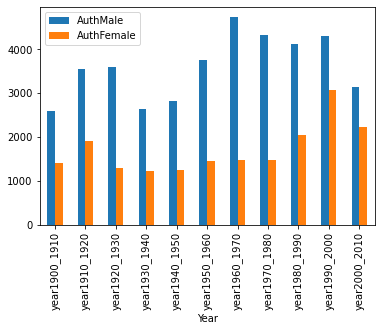

In [26]:
auth_gender_df.plot(x="Year", y=["AuthMale","AuthFemale"], kind="bar")